In [1]:
# Import libraries.
%pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


try:
  # %tensorflow_version only exists in Colab.ls
  
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from keras import layers
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


2023-09-09 09:14:12.358138: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-09 09:14:12.383771: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-09 09:14:12.582113: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-09 09:14:12.584595: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-09 09:14:14.217260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [11]:

# load and visualize the data
dataset = pd.read_csv('insurance.csv')
print(f"My dataset has {dataset.shape[0]} rows and {dataset.shape[1]} columns.")



My dataset has 1338 rows and 7 columns.


,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [34]:
dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [35]:
dataset.info

<bound method DataFrame.info of       age     sex   bmi  children smoker     region  expenses
0      19  female  27.9         0    yes  southwest  16884.92
1      18    male  33.8         1     no  southeast   1725.55
2      28    male  33.0         3     no  southeast   4449.46
3      33    male  22.7         0     no  northwest  21984.47
4      32    male  28.9         0     no  northwest   3866.86
...   ...     ...   ...       ...    ...        ...       ...
1333   50    male  31.0         3     no  northwest  10600.55
1334   18  female  31.9         0     no  northeast   2205.98
1335   18  female  36.9         0     no  southeast   1629.83
1336   21  female  25.8         0     no  southwest   2007.95
1337   61  female  29.1         0    yes  northwest  29141.36

[1338 rows x 7 columns]>

In [12]:
# split data for training and testing
y = dataset.expenses
data_features = ['age', 'sex', 'bmi', 'children', 'smoker']
X = dataset[data_features]

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 0)

In [36]:
dataset.describe

<bound method NDFrame.describe of       age     sex   bmi  children smoker     region  expenses
0      19  female  27.9         0    yes  southwest  16884.92
1      18    male  33.8         1     no  southeast   1725.55
2      28    male  33.0         3     no  southeast   4449.46
3      33    male  22.7         0     no  northwest  21984.47
4      32    male  28.9         0     no  northwest   3866.86
...   ...     ...   ...       ...    ...        ...       ...
1333   50    male  31.0         3     no  northwest  10600.55
1334   18  female  31.9         0     no  northeast   2205.98
1335   18  female  36.9         0     no  southeast   1629.83
1336   21  female  25.8         0     no  southwest   2007.95
1337   61  female  29.1         0    yes  northwest  29141.36

[1338 rows x 7 columns]>

In [14]:
# check for missing values
cols_missing = [col for col in train_X.columns if train_X[col].isnull().any()]
print(f"There are {len(cols_missing)} columns that have no values")

There are 0 columns that have no values


In [18]:
# check for categorical values
categ = (train_X.dtypes == 'object')
categ_cols = list(categ[categ].index)
print(f"Columns with categorical values are {categ_cols}")
print("validation data:\n", val_X)

Columns with categorical values are ['sex', 'smoker']
validation data:
       age     sex   bmi  children smoker
578    52    male  30.2         1     no
610    47  female  29.4         1     no
569    48    male  40.6         2    yes
1034   61    male  38.4         0     no
198    51  female  18.1         0     no
...   ...     ...   ...       ...    ...
1084   62  female  30.5         2     no
726    41    male  28.4         1     no
1132   57    male  40.3         0     no
725    30  female  39.1         3    yes
963    46    male  24.8         3     no

[268 rows x 5 columns]


In [20]:
# process categorical values
from sklearn.preprocessing import OneHotEncoder

my_encoder = OneHotEncoder(handle_unknown='ignore', sparse = False)

OH_cols_train = pd.DataFrame(my_encoder.fit_transform(train_X[categ_cols]))
OH_cols_val = pd.DataFrame(my_encoder.transform(val_X[categ_cols]))

OH_cols_train.index = train_X.index
OH_cols_val.index = val_X.index

num_train_X = train_X.drop(categ_cols, axis = 1)
num_val_X = val_X.drop(categ_cols, axis = 1)


OH_train_X = pd.concat([num_train_X, OH_cols_train], axis = 1)
OH_val_X = pd.concat([num_val_X, OH_cols_val], axis = 1)

OH_train_X.columns = OH_train_X.columns.astype(str)
OH_val_X.columns = OH_val_X.columns.astype(str)

OH_train_X.rename(columns = {'2' : 'no smoking'}, inplace = True)
OH_val_X.rename(columns = {'2' : 'no smoking'}, inplace = True)
OH_train_X.rename(columns = {'3' : 'yes smoking'}, inplace = True)
OH_val_X.rename(columns = {'3' : 'yes smoking'}, inplace = True)

OH_train_X.rename(columns = {'1' : 'male'}, inplace = True)
OH_val_X.rename(columns = {'1' : 'male'}, inplace = True)
OH_train_X.rename(columns = {'0' : 'female'}, inplace = True)
OH_val_X.rename(columns = {'0' : 'female'}, inplace = True)


print("Post encoding validation data\n", OH_val_X)




Post encoding validation data
       age   bmi  children  female  male  no smoking  yes smoking
578    52  30.2         1     0.0   1.0         1.0          0.0
610    47  29.4         1     1.0   0.0         1.0          0.0
569    48  40.6         2     0.0   1.0         0.0          1.0
1034   61  38.4         0     0.0   1.0         1.0          0.0
198    51  18.1         0     1.0   0.0         1.0          0.0
...   ...   ...       ...     ...   ...         ...          ...
1084   62  30.5         2     1.0   0.0         1.0          0.0
726    41  28.4         1     0.0   1.0         1.0          0.0
1132   57  40.3         0     0.0   1.0         1.0          0.0
725    30  39.1         3     1.0   0.0         0.0          1.0
963    46  24.8         3     0.0   1.0         1.0          0.0

[268 rows x 7 columns]


/home/michels/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [21]:
for data in OH_train_X.select_dtypes("object"):
    OH_train_X[data], _ = OH_train_X[data].factorize()

# for data in OH_train_X.select_dtypes("float64"):
#     OH_train_X[data], _ = OH_train_X[data].factorize

print(OH_train_X)
discrete_features = (OH_train_X.dtypes == int) | (OH_train_X.dtypes == 'int64')
print(discrete_features)

      age   bmi  children  female  male  no smoking  yes smoking
621    37  34.1         4     0.0   1.0         0.0          1.0
194    18  34.4         0     0.0   1.0         1.0          0.0
240    23  36.7         2     1.0   0.0         0.0          1.0
1168   32  35.2         2     0.0   1.0         1.0          0.0
1192   58  32.4         1     1.0   0.0         1.0          0.0
...   ...   ...       ...     ...   ...         ...          ...
763    27  26.0         0     0.0   1.0         1.0          0.0
835    42  36.0         2     0.0   1.0         1.0          0.0
1216   40  25.1         0     0.0   1.0         1.0          0.0
559    19  35.5         0     0.0   1.0         1.0          0.0
684    33  18.5         1     1.0   0.0         1.0          0.0

[1070 rows x 7 columns]
age             True
bmi            False
children        True
female         False
male           False
no smoking     False
yes smoking    False
dtype: bool


age            1.372236
no smoking     0.367263
yes smoking    0.367263
children       0.141411
female         0.116587
male           0.116587
bmi            0.096150
Name: MI Scores, dtype: float64


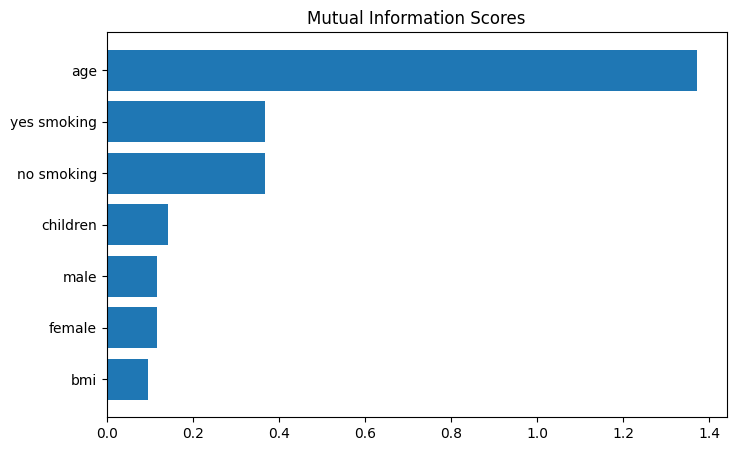

In [22]:
# Mutual Information check
from sklearn.feature_selection import mutual_info_regression
def make_mi_score(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name = 'MI Scores', index = X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_score(OH_train_X, train_y, discrete_features)
print(mi_scores)

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")



plt.figure(dpi = 100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [39]:
# Training Model and Predictions of costs
my_model= GradientBoostingRegressor(n_estimators=100)
my_model.fit(OH_train_X, train_y)
predict = my_model.predict(OH_val_X)
score = mean_absolute_error(val_y, predict)
print(score)



2374.9783738885744


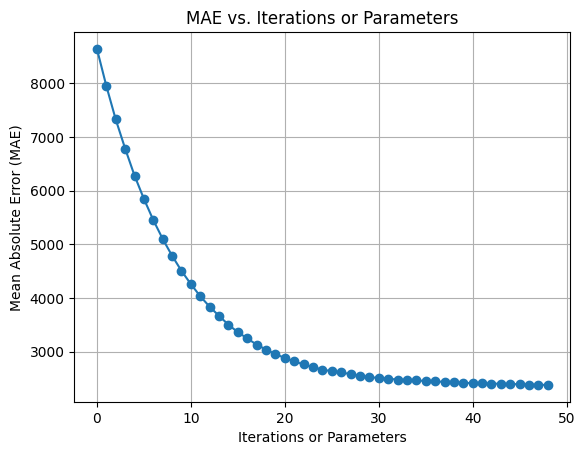

In [42]:
mae_values = []

parameter_range = range(1, 50) 

for param in parameter_range:
    # Create and train your model with the current parameter value
    my_model = GradientBoostingRegressor(n_estimators=param) 
    my_model.fit(OH_train_X, train_y)
    
    # Make predictions
    predict = my_model.predict(OH_val_X)
    score = mean_absolute_error(val_y, predict)
    mae_values.append(score)

# Plot the MAE values
plt.plot(range(len(mae_values)), mae_values, marker='o', linestyle='-')
plt.xlabel('Iterations or Parameters')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs. Iterations or Parameters')
plt.grid(True)
plt.show()